In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")


=========================================
## Dataset characteristics
=========================================	

day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
    

In [342]:
data = pd.read_csv('day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [343]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [344]:
data.shape

(730, 16)

In [345]:
# no mull or missing values in data set
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### Observation 
1. There are some categorical data represented in numerical form, this is not ideal for anylasis.
2. dteday object variable which can be broken down into simpler derived variables day, month, year. yr is already representing year in data set we drop this and replace it with new year variable.

In [346]:
# converting features from int to catgorical
# season - 1:spring, 2:summer, 3:fall, 4:winter
# holiday - 0: No 1: Yes
# workingday - 0: No 1: Yes
# weathersit - 1: A 2: B 3: C 4:D

data.season = data.season.apply(lambda x: {1: 'Season-Spring', 2: 'Season-Summer', 3: 'Season-Fall', 4: 'Season-Winter'}.get(x))
data.holiday = data.holiday.apply(lambda x: {1: 'holiday-Yes', 0: 'holiday-No'}.get(x))
data.workingday = data.workingday.apply(lambda x: {1: 'workingday-Yes', 0: 'workingday-No'}.get(x))
data.weathersit = data.weathersit.apply(lambda x: {1: 'weathersit-A', 2: 'weathersit-B', 3: 'weathersit-C', 4: 'weathersit-D'}.get(x))


In [347]:
data.weathersit.value_counts()

weathersit-A    463
weathersit-B    246
weathersit-C     21
Name: weathersit, dtype: int64

In [348]:
# convert dtedate to day, month and year
data.dteday = pd.to_datetime(data.dteday)
data.dteday.head()

0   2018-01-01
1   2018-02-01
2   2018-03-01
3   2018-04-01
4   2018-05-01
Name: dteday, dtype: datetime64[ns]

In [349]:
data['day'] = data.dteday.dt.day
data['month'] = data.dteday.dt.month
data['year'] = data.dteday.dt.year

In [350]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,month,year
0,1,2018-01-01,Season-Spring,0,1,holiday-No,6,workingday-No,weathersit-B,14.110847,18.18125,80.5833,10.749882,331,654,985,1,1,2018
1,2,2018-02-01,Season-Spring,0,1,holiday-No,0,workingday-No,weathersit-B,14.902598,17.68695,69.6087,16.652113,131,670,801,1,2,2018
2,3,2018-03-01,Season-Spring,0,1,holiday-No,1,workingday-Yes,weathersit-A,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,3,2018
3,4,2018-04-01,Season-Spring,0,1,holiday-No,2,workingday-Yes,weathersit-A,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,4,2018
4,5,2018-05-01,Season-Spring,0,1,holiday-No,3,workingday-Yes,weathersit-A,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,5,2018


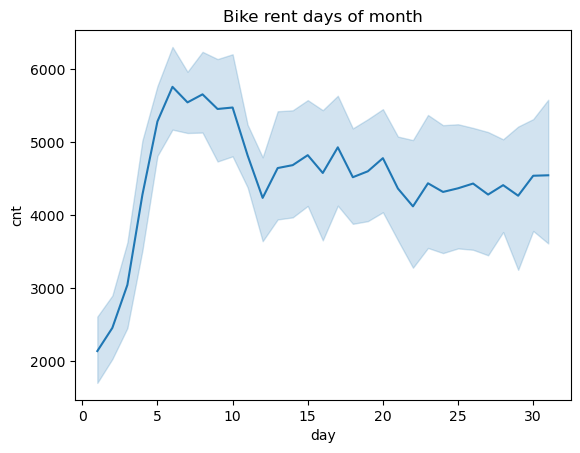

In [351]:
# Visulizing data distrbution of bike reneted by days
plt.title('Bike rent days of month')
sns.lineplot(x = data.day, y = data.cnt, legend='auto')
plt.show()

# Observation - Peak is around 5-10 i.e. max no of bikes are rented during this period.

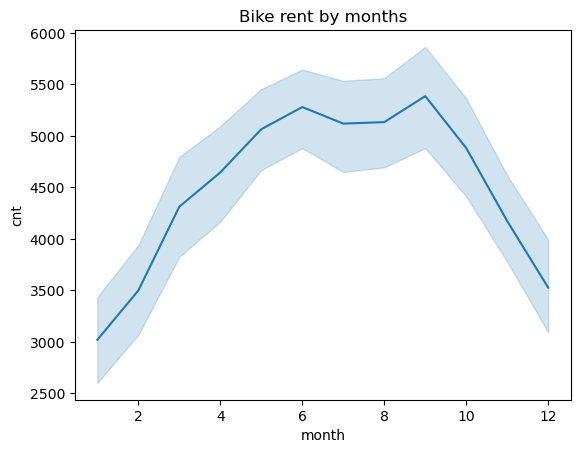

month
9     323187
8     318314
7     317424
6     316827
5     314049
10    302671
4     278737
3     267401
11    250389
12    218640
2     195934
1     187272
Name: cnt, dtype: int64


In [352]:
plt.title('Bike rent by months')
sns.lineplot(x = data.month, y = data.cnt, legend='auto')
plt.show()

print((data.groupby('month').sum().cnt).sort_values(ascending=False))


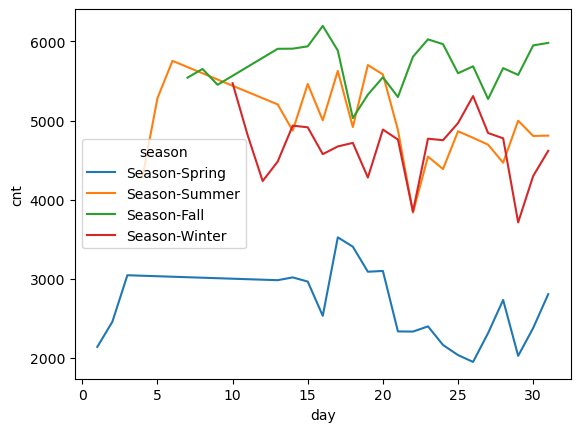

season
Season-Fall      1061129
Season-Summer     918589
Season-Winter     841613
Season-Spring     469514
Name: cnt, dtype: int64


In [353]:
sns.lineplot(data=data, x="day", y="cnt", hue="season", err_style=None)
plt.show()

print((data.groupby('season').sum().cnt).sort_values(ascending=False))

# Max number of bikes are rented in fall

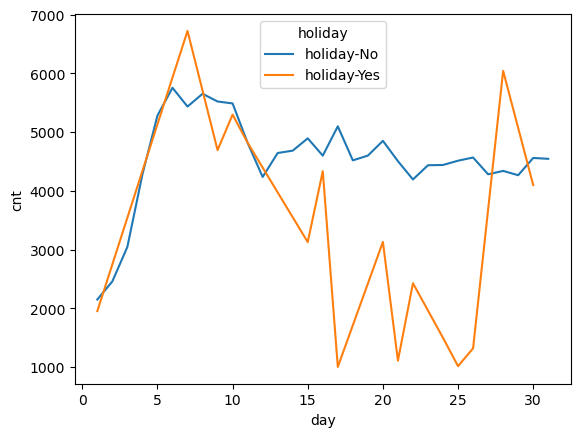

Bike rented per holiday holiday
holiday-No     3212410
holiday-Yes      78435
Name: cnt, dtype: int64 


Holiday Value counts 
 holiday-No     709
holiday-Yes     21
Name: holiday, dtype: int64


In [354]:
sns.lineplot(data=data, x="day", y="cnt", hue="holiday", err_style=None)
plt.show()

print('Bike rented per holiday', (data.groupby('holiday').sum().cnt).sort_values(ascending=False), '\n\n')
print('Holiday Value counts \n', data.holiday.value_counts())

# Max no of bikes are rented when there is no holiday this is cause non-holiday frequency is way smaller than holidays

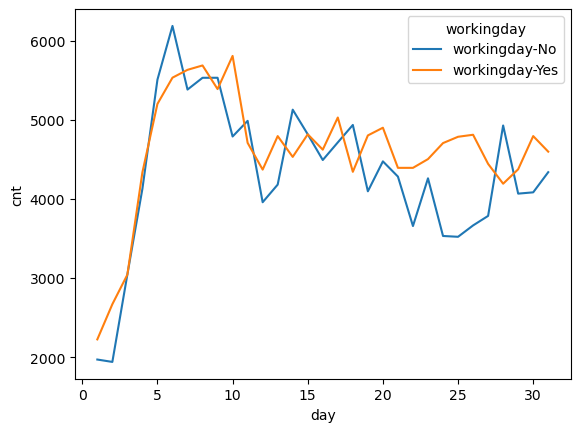

workingday
workingday-Yes    2290576
workingday-No     1000269
Name: cnt, dtype: int64 


workingday-Yes    499
workingday-No     231
Name: workingday, dtype: int64


In [355]:
sns.lineplot(data=data, x="day", y="cnt", hue="workingday", err_style=None)
plt.show()

print((data.groupby('workingday').sum().cnt).sort_values(ascending=False), '\n\n')
print(data.workingday.value_counts())

# Observation more no of bikes are rented on working days - Majorly cause there are greater no of working days than non-working days

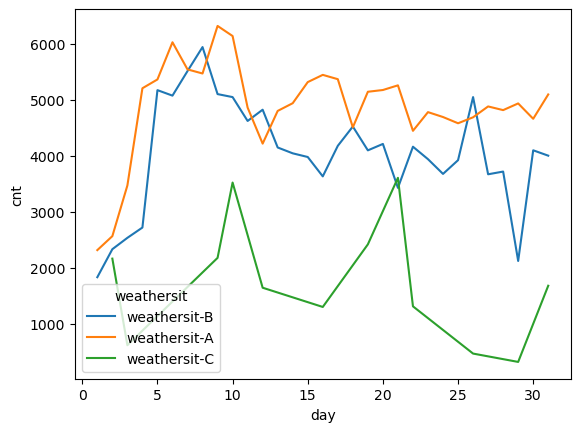

weathersit
weathersit-A    2257952
weathersit-B     995024
weathersit-C      37869
Name: cnt, dtype: int64 


weathersit-A    463
weathersit-B    246
weathersit-C     21
Name: weathersit, dtype: int64


'\nObservations - \n    - Max no of bikes are rented for (A: Clear, Few clouds, Partly cloudy, Partly cloudy) which is roughly 2.2 time B\n    - Max no after A (B: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist) which is roughly 26 time C\n    - After B third most tbikes are rented in C: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds\n    - No bikes are rented in D: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog\n'

In [356]:
sns.lineplot(data=data, x="day", y="cnt", hue="weathersit", err_style=None)
plt.show()


print((data.groupby('weathersit').sum().cnt).sort_values(ascending=False), '\n\n')
print(data.weathersit.value_counts())

"""
Observations - 
    - Max no of bikes are rented for (A: Clear, Few clouds, Partly cloudy, Partly cloudy) which is roughly 2.2 time B
    - Max no after A (B: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist) which is roughly 26 time C
    - After B third most tbikes are rented in C: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - No bikes are rented in D: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
"""

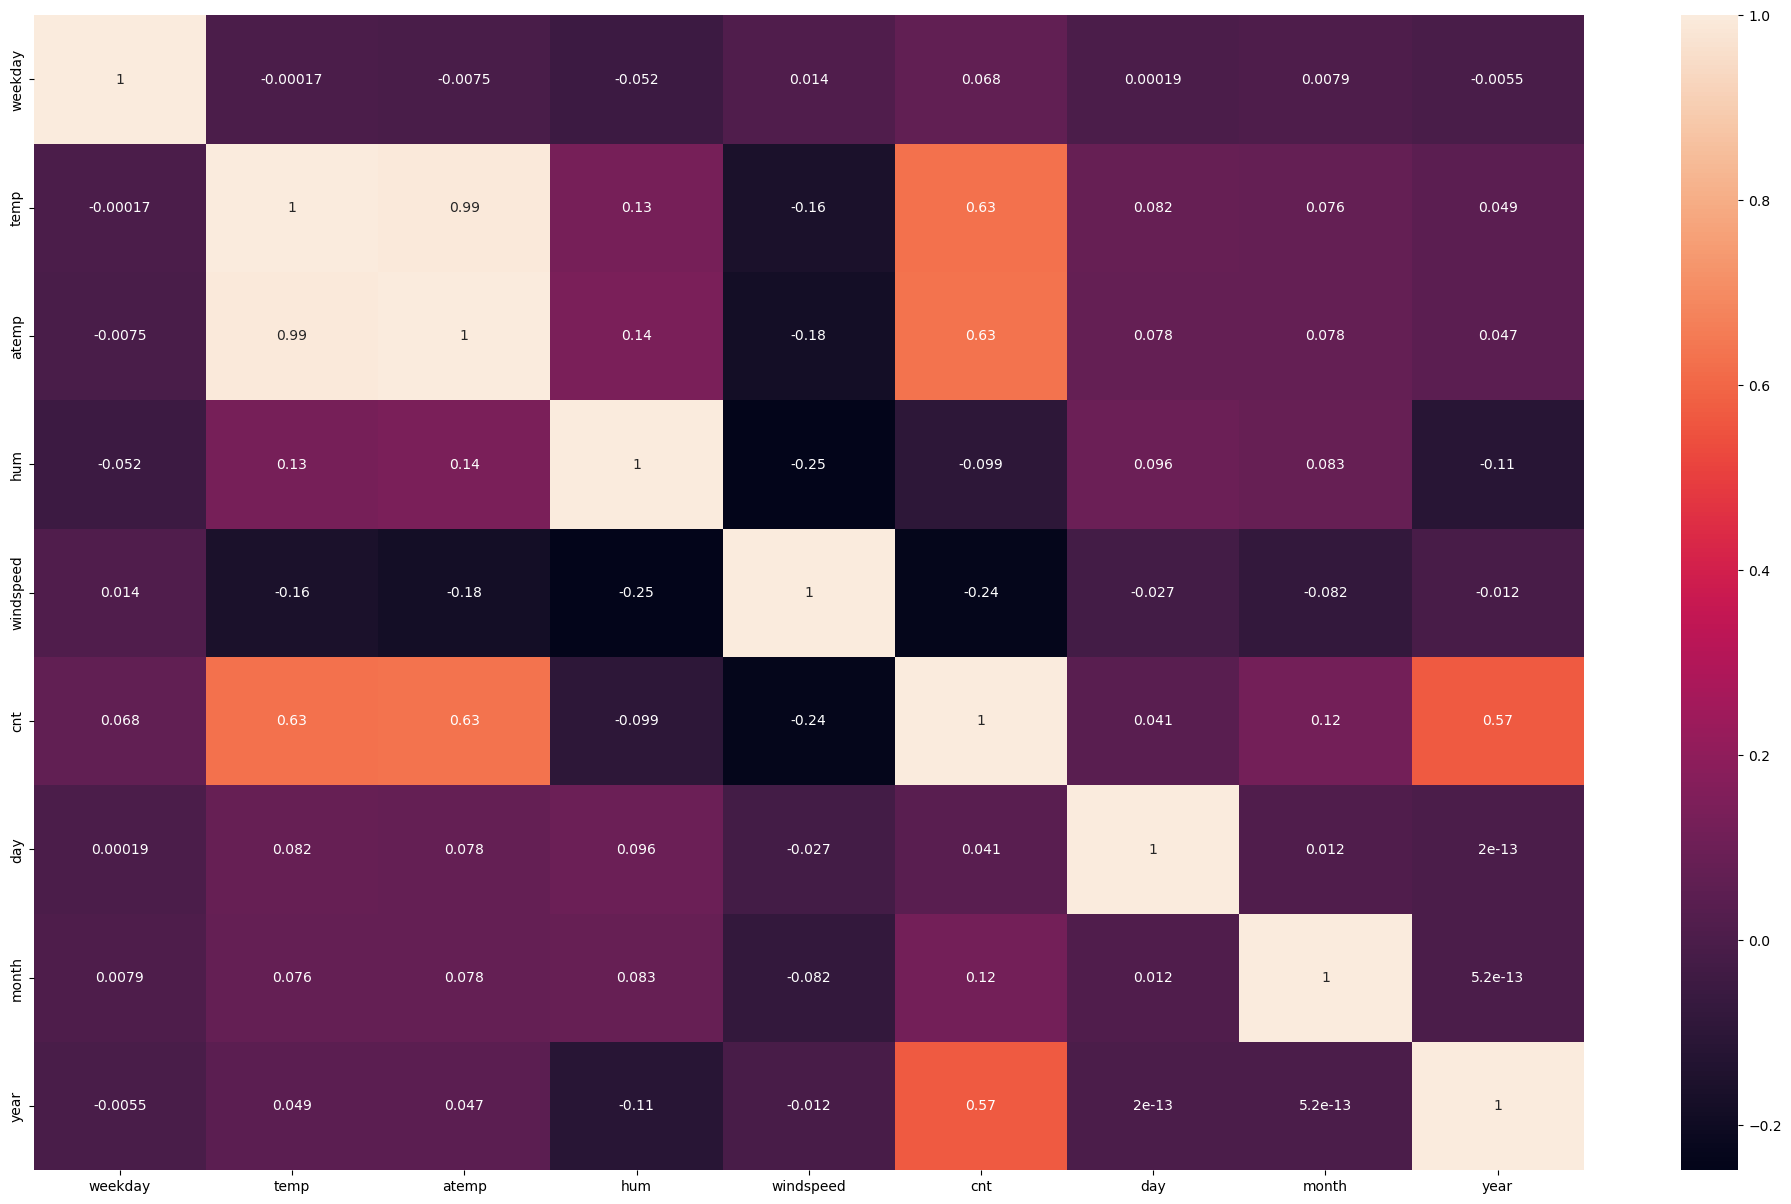

In [357]:
plt.figure(figsize=(25,15))
sns.heatmap(data.drop(['instant', 'casual', 'registered', 'yr', 'mnth'], axis=1).corr(), annot=True)
plt.show()

# 1st most positive correlation of tmp and atmp - as they basically represent same feature(temprature)
# 2nd most positive correlation of tmp with cnt

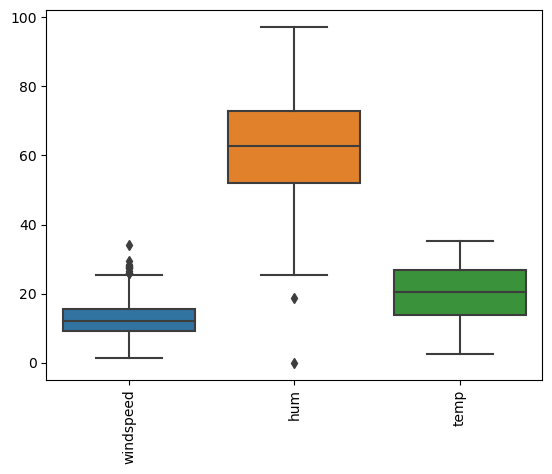

In [358]:
sns.boxplot(data[['windspeed', 'hum', 'temp']])
plt.xticks(rotation = 90)
plt.show()

# windspeed distributoin looks mostly continous so no signiificant outliers.
# for hum outlier dist is not continous and we can remove extreme ones

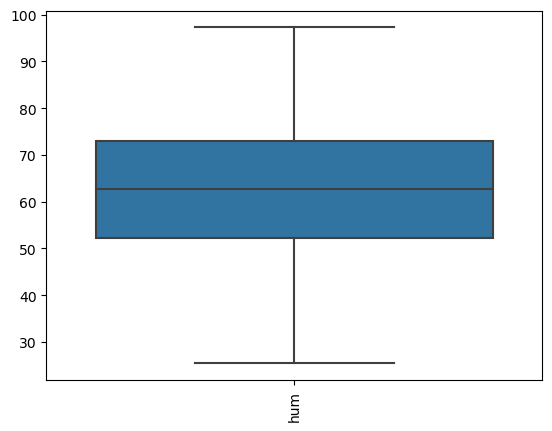

In [359]:
# removing hum outliers
hum_iqr = data.hum.quantile([0.75]).to_list()[0] - data.hum.quantile([0.25]).to_list()[0]
hum_lower_bound = data.hum.quantile([0.25]).to_list()[0] - (1.5 * hum_iqr) # Q1 - 1.5 * IQR
hum_upper_bound = data.hum.quantile([0.75]).to_list()[0] + (1.5 * hum_iqr) # Q3 - 1.5 * IQR

data = data[(data.hum >= hum_lower_bound) & (data.hum <= hum_upper_bound)]

sns.boxplot(data[['hum']])
plt.xticks(rotation = 90)
plt.show()

In [360]:
data.shape

(728, 19)

In [361]:
# convert categorical variables to dummy variables
# Adding additional column for weathersit category 4, since it does not contain any data it is not capured in feature transformation
data = pd.concat([data, pd.get_dummies(data.holiday), pd.get_dummies(data.season), pd.get_dummies(data.workingday), pd.get_dummies(data.weathersit)], axis=1)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,holiday-Yes,Season-Fall,Season-Spring,Season-Summer,Season-Winter,workingday-No,workingday-Yes,weathersit-A,weathersit-B,weathersit-C
0,1,2018-01-01,Season-Spring,0,1,holiday-No,6,workingday-No,weathersit-B,14.110847,...,0,0,1,0,0,1,0,0,1,0
1,2,2018-02-01,Season-Spring,0,1,holiday-No,0,workingday-No,weathersit-B,14.902598,...,0,0,1,0,0,1,0,0,1,0
2,3,2018-03-01,Season-Spring,0,1,holiday-No,1,workingday-Yes,weathersit-A,8.050924,...,0,0,1,0,0,0,1,1,0,0
3,4,2018-04-01,Season-Spring,0,1,holiday-No,2,workingday-Yes,weathersit-A,8.200000,...,0,0,1,0,0,0,1,1,0,0
4,5,2018-05-01,Season-Spring,0,1,holiday-No,3,workingday-Yes,weathersit-A,9.305237,...,0,0,1,0,0,0,1,1,0,0


In [362]:
# data distribution by categorical variables
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 0 to 729
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   instant         728 non-null    int64         
 1   dteday          728 non-null    datetime64[ns]
 2   season          728 non-null    object        
 3   yr              728 non-null    int64         
 4   mnth            728 non-null    int64         
 5   holiday         728 non-null    object        
 6   weekday         728 non-null    int64         
 7   workingday      728 non-null    object        
 8   weathersit      728 non-null    object        
 9   temp            728 non-null    float64       
 10  atemp           728 non-null    float64       
 11  hum             728 non-null    float64       
 12  windspeed       728 non-null    float64       
 13  casual          728 non-null    int64         
 14  registered      728 non-null    int64         
 15  cnt   

In [363]:
# drop unnessary columns
data = data.drop(['dteday', 'yr', 'instant', 'mnth', 
                  'season', 'holiday', 'workingday', 
                  'weathersit', 'casual', 'registered'], axis=1)

"""
R2 score - test/ train -> 83/80
data = data.drop(['dteday', 'yr', 'instant', 'mnth', 
                  'season', 'holiday', 'workingday', 
                  'weathersit', 'casual', 'registered'], axis=1)
                  




"""

"\nR2 score - test/ train -> 83/80\ndata = data.drop(['dteday', 'yr', 'instant', 'mnth', \n                  'season', 'holiday', 'workingday', \n                  'weathersit', 'casual', 'registered'], axis=1)\n                  \n\n\n\n\n"

In [364]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
weekday,728.0,2.991758,2.005478,0.000000,1.000000,3.000000,5.000000,6.000000
temp,728.0,20.330688,7.513864,2.424346,13.794799,20.551250,26.889153,35.328347
atemp,728.0,23.738133,8.158383,3.953480,16.881400,24.431350,30.477187,42.044800
hum,728.0,62.911794,13.970200,25.416700,52.156225,62.708350,73.010425,97.250000
windspeed,728.0,12.727880,5.139840,1.500244,9.031466,12.125057,15.624735,29.584721
cnt,728.0,4517.289835,1930.350041,22.000000,3193.000000,4551.000000,5978.500000,8714.000000
day,728.0,15.733516,8.800893,1.000000,8.000000,16.000000,23.000000,31.000000
month,728.0,6.527473,3.448471,1.000000,4.000000,7.000000,10.000000,12.000000
year,728.0,2018.501374,0.500342,2018.000000,2018.000000,2019.000000,2019.000000,2019.000000
holiday-No,728.0,0.971154,0.167489,0.000000,1.000000,1.000000,1.000000,1.000000


## EDA

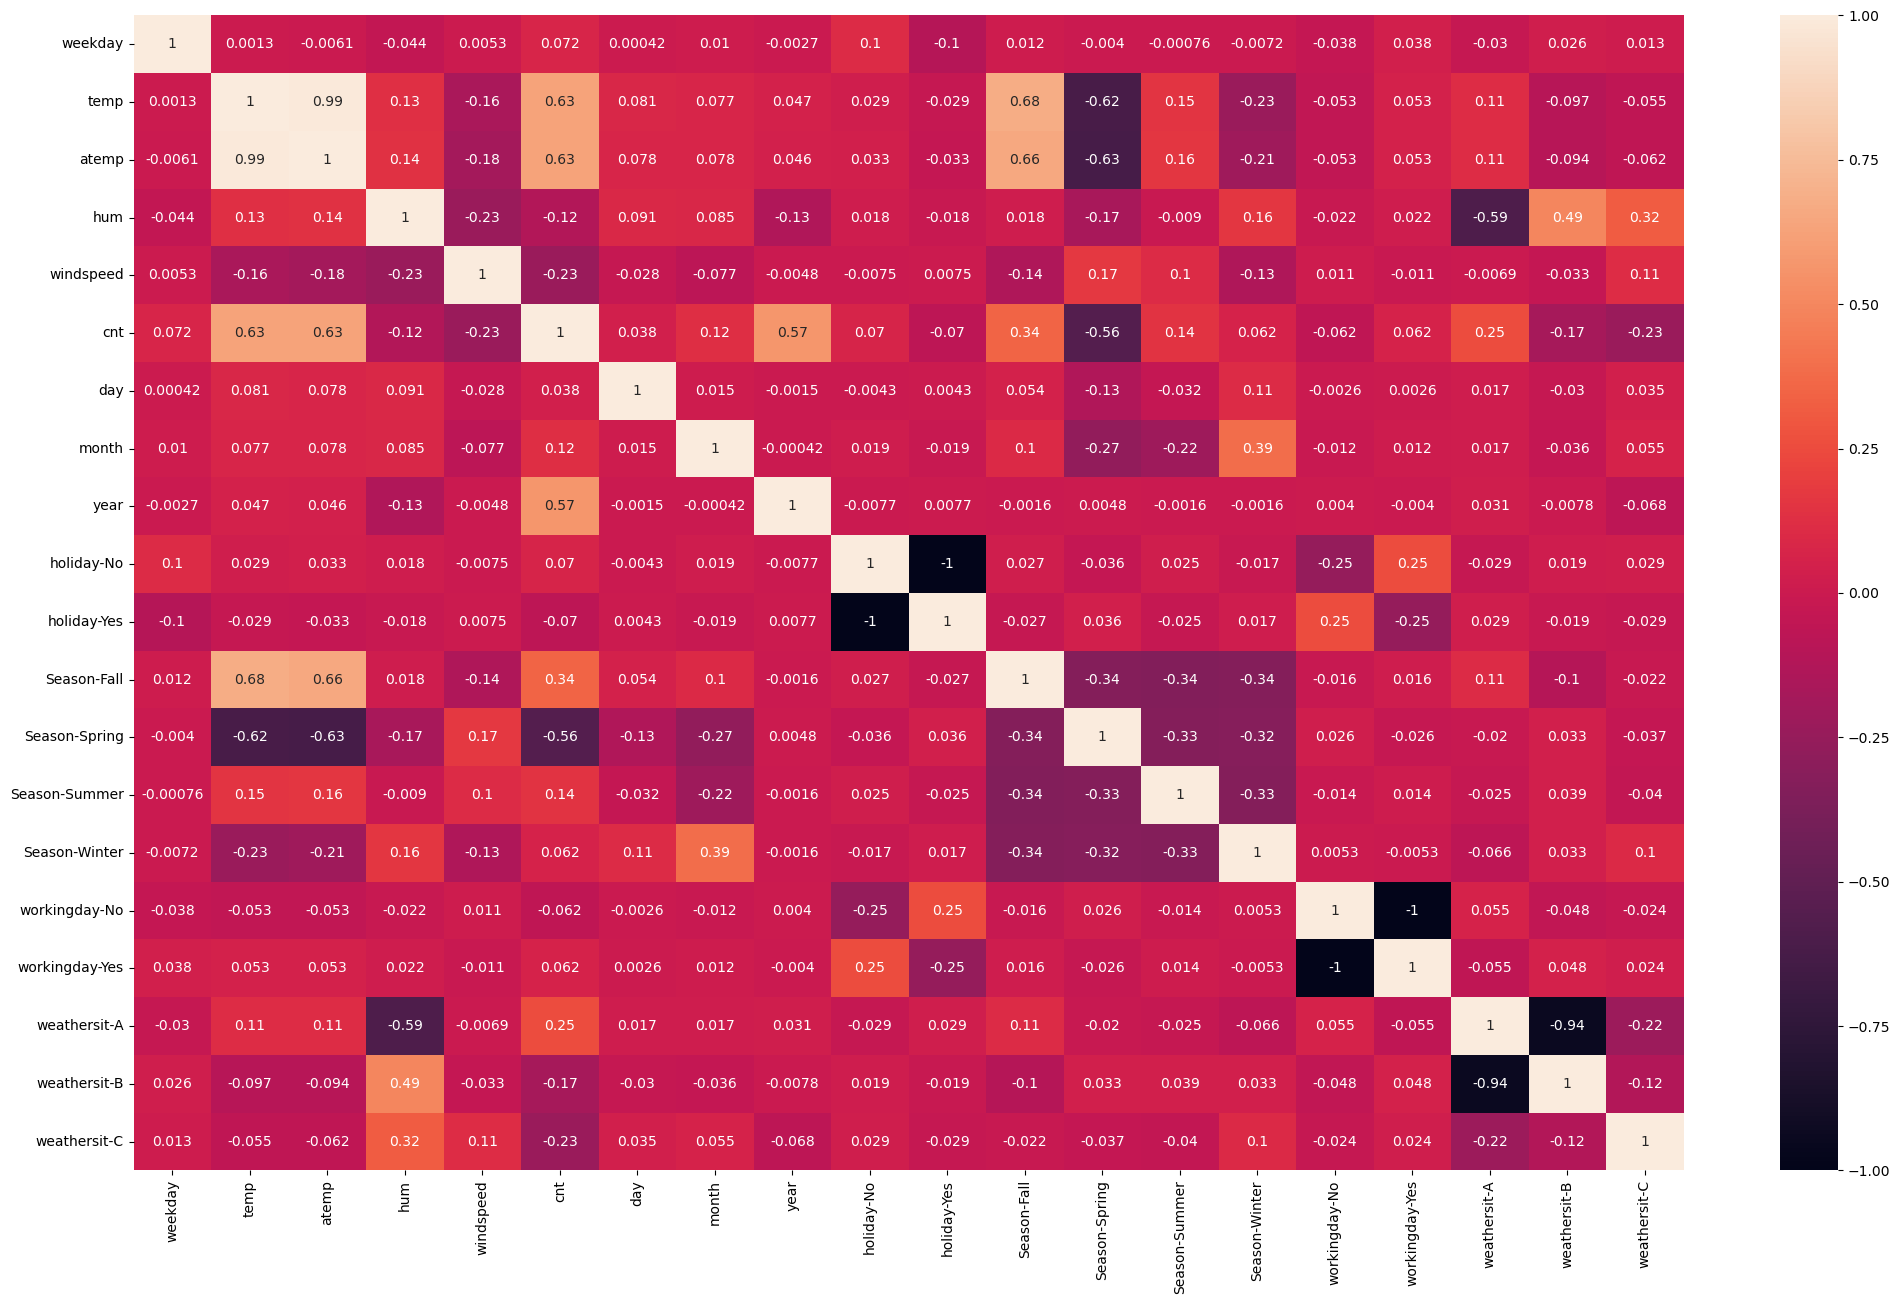

In [365]:
# correlation anylasis

plt.figure(figsize=(25,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

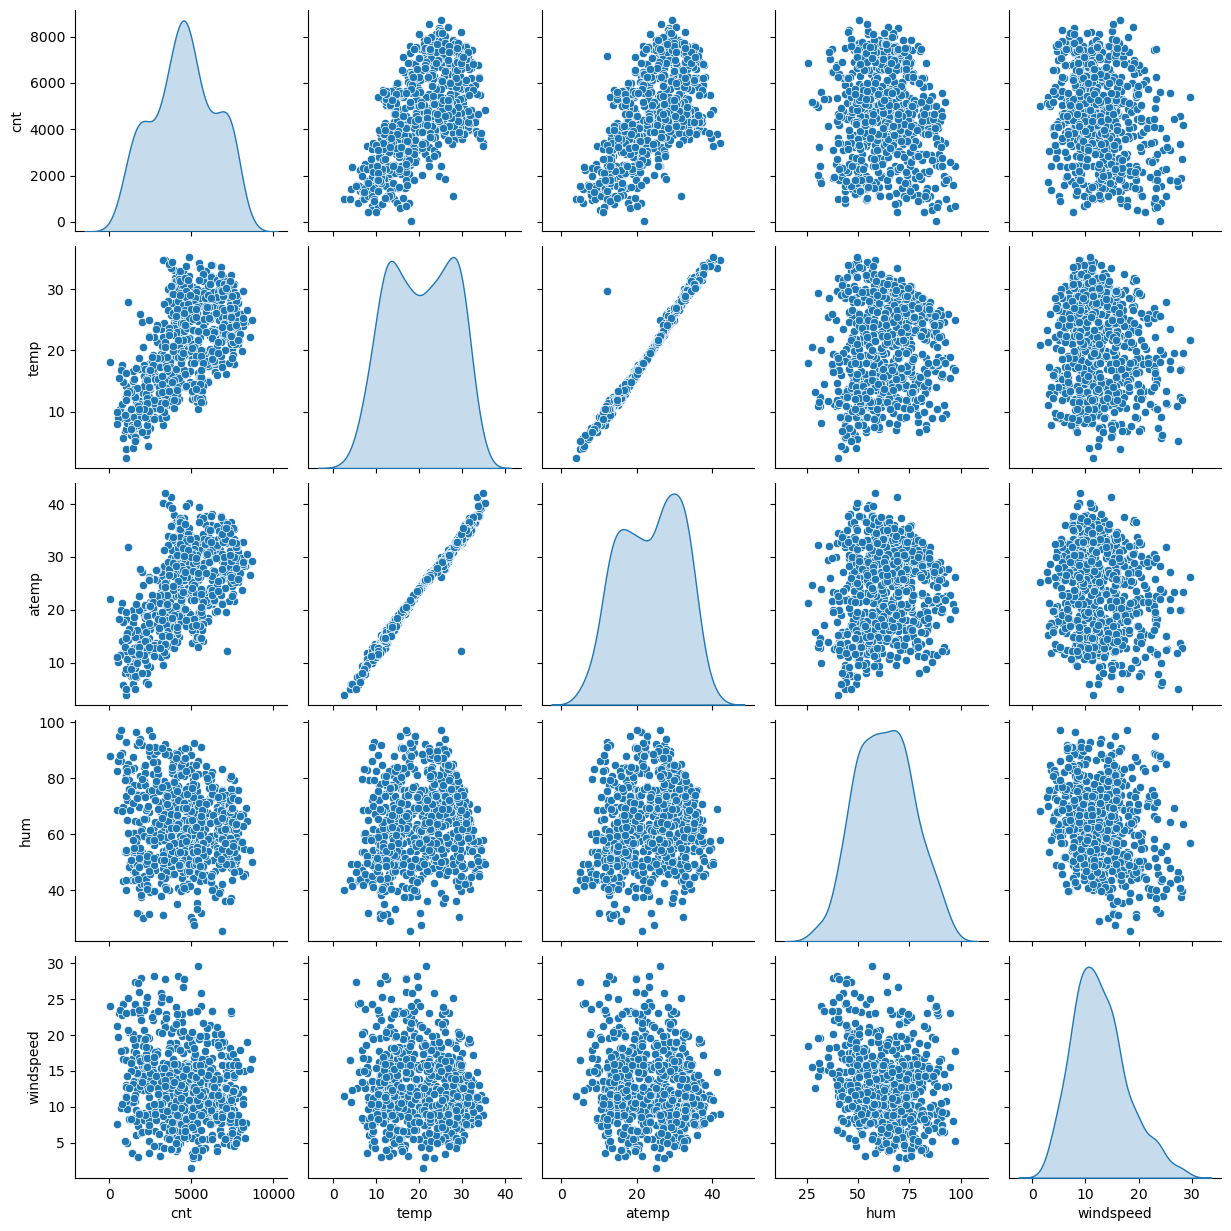

In [366]:
# Pair plot
sns.pairplot(data[['cnt', 'temp', 'atemp', 'hum', 'windspeed']], diag_kind='kde')
plt.show()

Positive correlation of temp and cnt

# Building Model

## Test Train Split

In [449]:
# testing removing some other features
# dropping columns - This is updated for each RFE iteration

# data = data.drop(['month'], axis=1) #still 83
# data = data.drop(['atemp'], axis=1) #still 83
# data = data.drop(['day'], axis=1)
# data = data.drop(['holiday-Yes'], axis=1)
# data = data.drop(['workingday-No'], axis=1)
# data = data.drop(['weathersit-A'], axis=1)
# data = data.drop(['Season-Fall'], axis=1)
# data = data.drop(['workingday-Yes'], axis=1)
# data = data.drop(['hum'], axis=1)

data = data.drop(['holiday-No'], axis=1)


In [450]:
X = data.loc[:, data.columns != 'cnt']
y = data['cnt']

In [451]:
# building a basic model
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

## Rescaling features

In [452]:
X_train.head()

,weekday,temp,windspeed,year,Season-Spring,Season-Summer,Season-Winter,weathersit-B,weathersit-C
728,0,10.489153,23.500518,2019,1,0,0,0,0
481,5,18.757500,23.291411,2019,0,1,0,0,0
113,0,23.848347,12.875725,2018,0,1,0,1,0
629,6,26.650000,19.000061,2019,0,0,0,0,0
535,3,32.082500,7.625404,2019,0,1,0,0,0


In [453]:
# Scale features which were originally numeric or float type
num_vars = ['weekday', 'temp', 'windspeed', 'year']
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train.head()

,weekday,temp,windspeed,year,Season-Spring,Season-Summer,Season-Winter,weathersit-B,weathersit-C
728,0.000000,0.245101,0.772556,1.0,1,0,0,0,0
481,0.833333,0.496388,0.764739,1.0,0,1,0,0,0
113,0.000000,0.651106,0.375373,0.0,0,1,0,1,0
629,1.000000,0.736253,0.604317,1.0,0,0,0,0,0
535,0.500000,0.901354,0.179101,1.0,0,1,0,0,0


In [454]:
# Only transform on test set 
X_test[num_vars] = scaler.transform(X_test[num_vars])

## Using multiple linear regression

In [455]:

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, step=10)             # running RFE
rfe = rfe.fit(X_train, y_train)


In [456]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
# I can also try creating derived feature from categorical variables+day to better predict the output, cause all categorical variables 
# right now are too broad to predict a continous value

[('weekday', False, 2),
 ('temp', True, 1),
 ('windspeed', True, 1),
 ('year', True, 1),
 ('Season-Spring', False, 2),
 ('Season-Summer', False, 2),
 ('Season-Winter', False, 2),
 ('weathersit-B', False, 2),
 ('weathersit-C', True, 1)]

In [457]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     266.8
Date:                Wed, 19 Jul 2023   Prob (F-statistic):          2.27e-184
Time:                        15:02:52   Log-Likelihood:                -4129.4
No. Observations:                 509   AIC:                             8279.
Df Residuals:                     499   BIC:                             8321.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1753.0249    258.472      6.782

In [465]:
# Calculate the VIFs for the model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,4.72
1,temp,4.46
0,weekday,3.02
4,Season-Spring,2.13
3,year,2.06
5,Season-Summer,1.80
6,Season-Winter,1.66
7,weathersit-B,1.59
8,weathersit-C,1.10


# Residual Analysis of the train data

In [460]:
y_train_pred = lm.predict(X_train)

Text(0.5, 0, 'Errors')

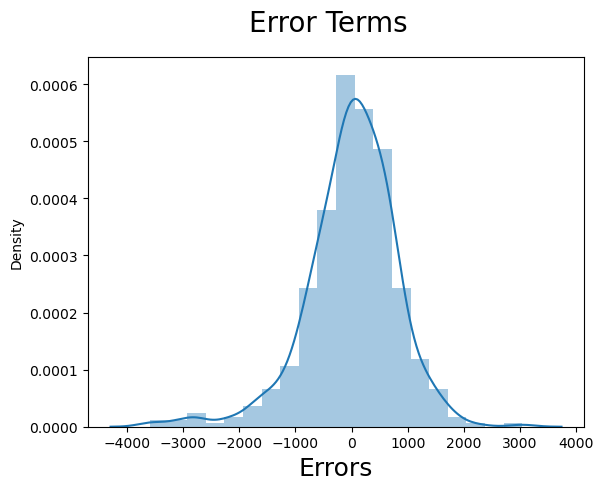

In [461]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

# Making predictions

In [462]:
y_pred = lm.predict(X_test)


Text(0, 0.5, 'y_pred')

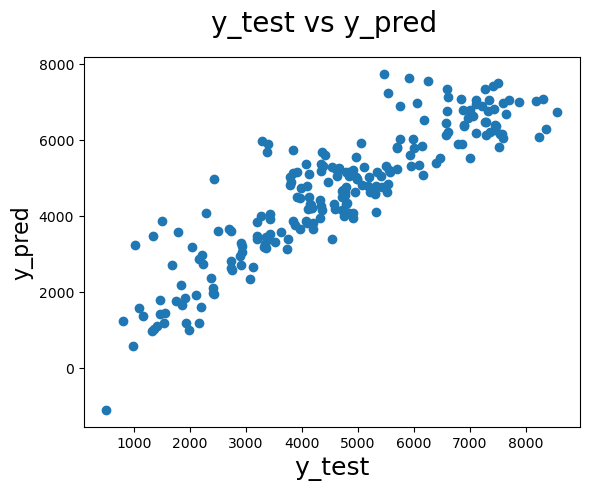

In [463]:
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [464]:
# R2 score on test set
r2_score(y_true=y_test, y_pred=y_pred)

0.7915902544115029

# Adjusted R2 score on test set is 79 and that on traning test is 82 which is close enough.